# BA 820 Homework 2

Group Name: Group A9
Member Names: Chuheng(Kevin) Yu, Sixuan(Wilson) Wang, Linting(Linsey) Wang, Yuhan(Sherry) Wang, Tyler Christoforo

Reminder: you should not be sharing code across groups

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [ ]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [ ]:
import glob
import numpy as np
books = glob.glob('./data/enron/*.txt')

shelf = []
for i in range(0,len(books)):
    temp = []
    temp = make_word_list(books[i])
    shelf.append(temp)
len(shelf)

5171

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=50, max_df=0.8, stop_words="english")
X = vectorizer.fit_transform(shelf)
words = vectorizer.vocabulary_
print(len(words))

1680


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina' 

In [ ]:
gm = GaussianMixture(n_components=3, random_state=11).fit(X.toarray())
prediction = gm.predict(X.toarray())

print("cluster 1:", len(prediction[prediction==0]))
print("cluster 2:", len(prediction[prediction==1]))
print("cluster 3:", len(prediction[prediction==2]))

cluster 1: 2607
cluster 2: 2200
cluster 3: 364


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [ ]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

In [ ]:
spam_words = ['buy', 'click', 'million']
spam_indices = []

for i in words.keys():
    for j in spam_words:
        if j == i:
            spam_indices.append(words[i])
spam_indices

[238, 180, 926]

In [ ]:
ham_words = ['regards', 'attached', 'thank']
ham_indices = []

for i in words.keys():
    for j in ham_words:
        if j == i:
            ham_indices.append(words[i])
ham_indices

[1233, 108, 1506]

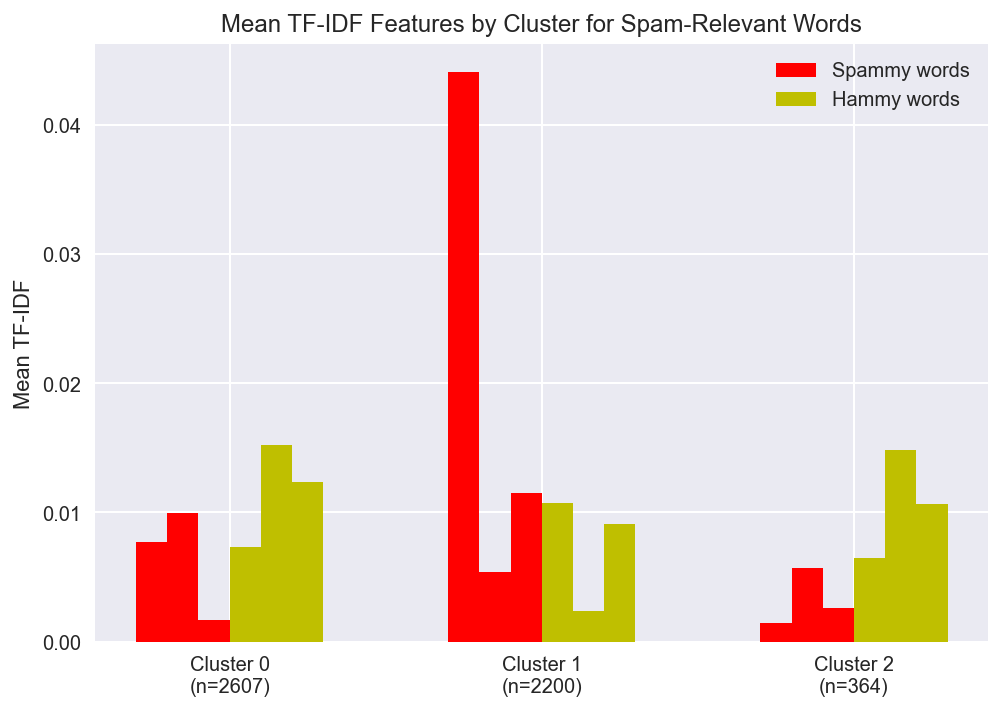

In [ ]:
plot_spam_words_by_cluster(X, prediction, 3, spam_indices, ham_indices)

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** WRITE YOUR ANSWER HERE IN TEXT ***

The plot generated in part d shows 3 clusters, within each cluster the frequency of each word is displayed by the height of the bar. Cluster 1 has a high frequency of spammmy words, specifically the word 'buy'. Cluster 0 and cluster 2 have a very similar distribution of hammy words. Cluster 2 shows less distribution of spammy words. From this, we can identify ones that are highly likely spam, but cannot see if ones are highly likely ham.

After changing the number of clusters, an obvious change can be observed. In te model with 5 clusters,spammy words and hammy words seems to be separated quite well. Similarly, cluster 1 has the most frequent spammy word. In the model with 2 clusters, cluster 0 is now the one with a high frequency spammy word, but no high frequency for hammy words. By comparison, 5 cluster model is more informative and useful for distinction.

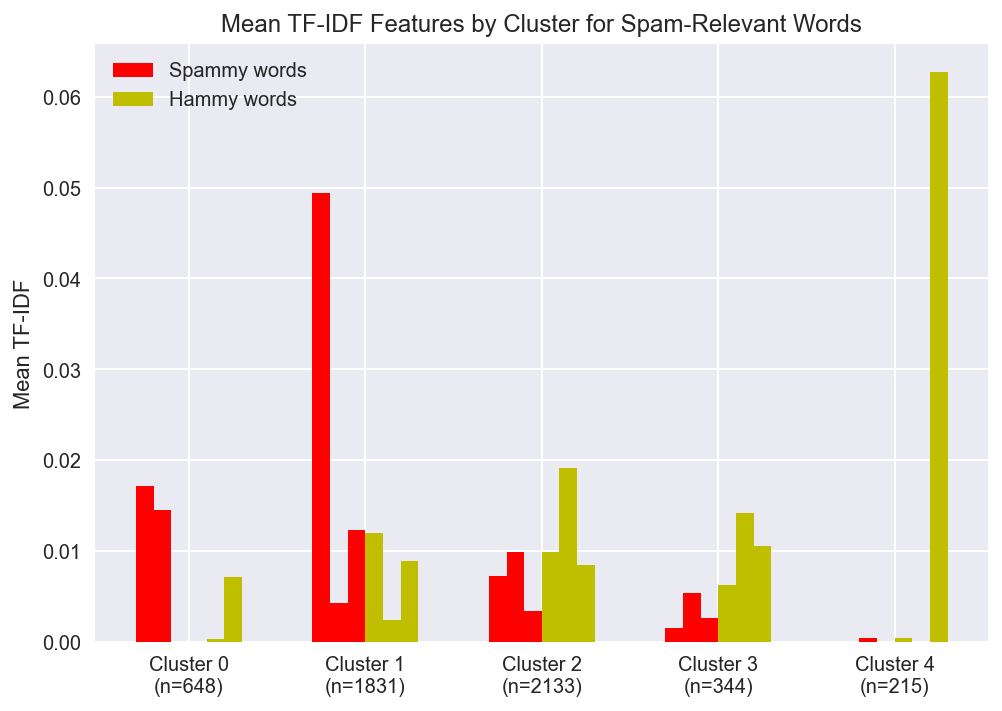

In [ ]:
gm5 = GaussianMixture(n_components=5, random_state=11).fit(X.toarray())
prediction5 = gm5.predict(X.toarray())
plot_spam_words_by_cluster(X, prediction5, 5, spam_indices, ham_indices)

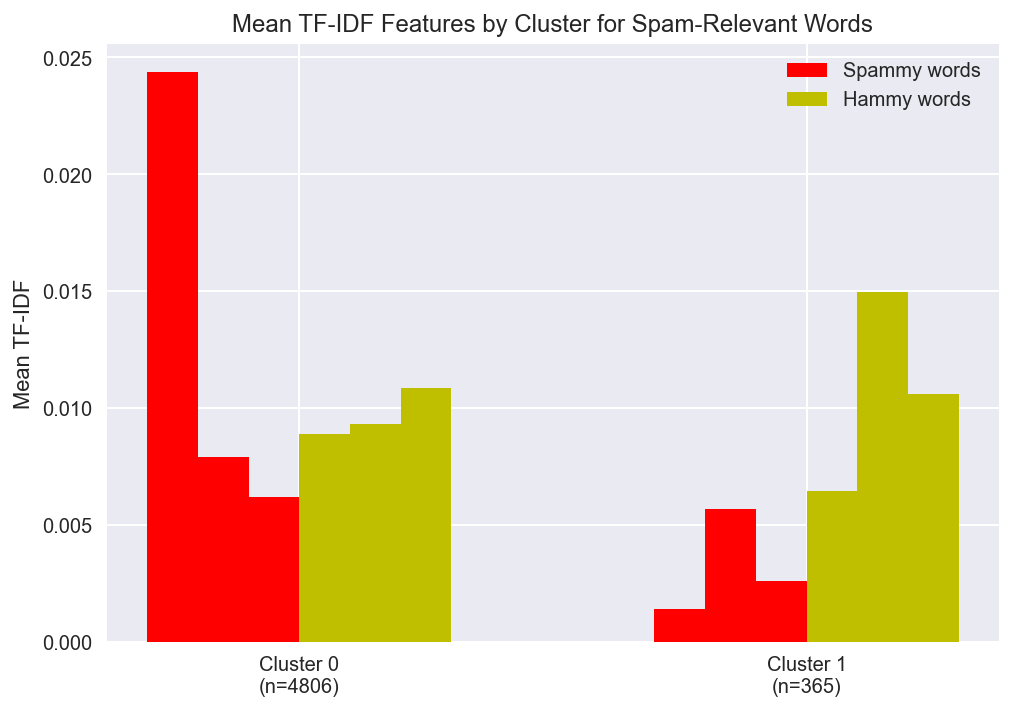

In [ ]:
gm2 = GaussianMixture(n_components=2, random_state=11).fit(X.toarray())
prediction2 = gm2.predict(X.toarray())
plot_spam_words_by_cluster(X, prediction2, 2, spam_indices, ham_indices)

## Question 2: Latent "Purposes" in Mobile Apps [50 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [ ]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [ ]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [ ]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [ ]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"]) 
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
del df # uncomment to free up RAM
del df_perms # uncomment to free up RAM

### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
new_X = transformer.fit_transform(X)

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_jobs=-1, max_iter=10, n_components=10, random_state=0)
result = lda.fit(new_X)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [ ]:
len(permission_columns)

173

In [ ]:
vec = TfidfVectorizer()
vec.fit_transform(permission_columns)

<173x286 sparse matrix of type '<class 'numpy.float64'>'
	with 917 stored elements in Compressed Sparse Row format>

In [ ]:
for index,topic in enumerate(lda.components_):
    #0, 173
    temp = [vec.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    print(f'Topic #{index}: {temp}')

Topic #0: ['allow', 'move', 'defaults', 'diag', 'directly', 'device', 'defined', 'data', 'limit', 'level']
Topic #1: ['app', 'bookmarks', 'fi', 'file', 'device', 'email', 'directly', 'defined', 'data', 'contacts']
Topic #2: ['kill', 'measure', 'dictionary', 'internet', 'known', 'fi', 'mount', 'hardware', 'defined', 'data']
Topic #3: ['defaults', 'keylock', 'device', 'data', 'file', 'authentication', 'defined', 'directly', 'kill', 'internet']
Topic #4: ['level', 'from', 'full', 'device', 'contacts', 'defined', 'directly', 'discover', 'data', 'file']
Topic #5: ['collapse', 'defaults', 'change', 'animation', 'field', 'device', 'defined', 'data', 'from', 'directly']
Topic #6: ['device', 'launching', 'contacts', 'defined', 'level', 'data', 'limit', 'directly', 'content', 'contents']
Topic #7: ['downloads', 'display', 'drm', 'create', 'docs', 'directly', 'data', 'defined', 'defaults', 'device']
Topic #8: ['limit', 'contacts', 'file', 'directly', 'diag', 'data', 'defined', 'default', 'device'

*** WRITE YOUR ANSWER HERE IN TEXT ***

Looking at the topics in the results, there are less meaningful and repetitive words like 'directly','file','data'. Meaningful words seem to have more action trigger, which from an app standpoint makes sense. By this understanding, topic #3,#4,#5,#7 and #9 are more meaningful topics that stand out. They have less filler words and more action words like 'delete','collapse'.

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [ ]:
apps_index = np.where(app_ratings >= 100000)[0]
apps_index = list(apps_index)
new_result = lda.fit_transform(X) 

In [ ]:
import pandas as pd

store =  pd.DataFrame(new_result)
new_df = pd.concat([pd.DataFrame({'app_name':app_names,'app_ratings':app_ratings}), store], axis=1)
new_df = new_df[new_df['app_ratings'] >= 100000]
new_df

,app_name,app_ratings,0,1,2,3,4,5,6,7,8,9
0,Google Maps,1438259,0.003847,0.181438,0.003848,0.317960,0.003848,0.003847,0.182792,0.003847,0.155009,0.143563
489,Facebook for Android,1897622,0.005001,0.005002,0.005001,0.714075,0.005001,0.005002,0.005001,0.005002,0.245912,0.005002
491,Pandora?? internet radio,650856,0.007694,0.546094,0.007695,0.007695,0.007696,0.007694,0.007694,0.007696,0.311478,0.088565
492,Zedge Ringtones & Wallpapers,240408,0.011113,0.011113,0.011116,0.011112,0.011112,0.369684,0.011112,0.011114,0.011112,0.541413
493,Advanced Task Killer,344603,0.016670,0.016675,0.016675,0.016669,0.472559,0.016672,0.016668,0.394068,0.016671,0.016672
...,...,...,...,...,...,...,...,...,...,...,...,...
29099,Pandora® internet radio,659115,0.007694,0.546094,0.007695,0.007695,0.007696,0.007694,0.007694,0.007696,0.311478,0.088565
29131,Dolphin Browser™ HD,219335,0.006669,0.329249,0.006668,0.006668,0.006670,0.164039,0.460032,0.006668,0.006669,0.006668
29134,Brightest Flashlight Free™,139279,0.009094,0.009099,0.009094,0.009092,0.009094,0.009094,0.918148,0.009095,0.009094,0.009094
29144,Handcent SMS,396166,0.003704,0.211081,0.003705,0.355829,0.003705,0.003705,0.003704,0.003705,0.003705,0.407157


In [ ]:
for i in range(10):
    temp_df = new_df.sort_values(by=[i], ascending=False)
    temp = list(temp_df['app_name'].head(3))
    print('Topic:', i, temp)

Topic: 0 ['Toss It', 'Paper Toss', 'GasBuddy']
Topic: 1 ['PowerAMP Music Player (Trial)', 'Pandora?? internet radio', 'Pandora® internet radio']
Topic: 2 ['Angry Birds Seasons', 'Yoo Ninja! Free', 'Adobe Reader']
Topic: 3 ['Gmail', 'Facebook for Android', 'Yahoo! Mail']
Topic: 4 ['ColorNote Notepad Notes', 'Advanced Task Killer', 'WeatherBug']
Topic: 5 ['Wallpapers HD', 'Strip Poker', 'Backgrounds HD Wallpapers']
Topic: 6 ['Brightest Flashlight Free™', 'Brightest Flashlight Free???', 'TweetCaster for Twitter']
Topic: 7 ['Live Holdem Poker Pro', 'Vaulty Free Hides Pictures', 'World Newspapers']
Topic: 8 ['TuneIn Radio', 'Restaurant Story™', 'Restaurant Story???']
Topic: 9 ['Ringdroid', 'GO Launcher EX', 'Zedge Ringtones & Wallpapers']


### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [15 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(angle=0.99, learning_rate='auto', random_state=11)
tsne_d = tsne.fit_transform(X)

/Users/chuhengyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=10, n_init=1000, random_state=0)
gm.fit(tsne_d)
pre = gm.predict(tsne_d)

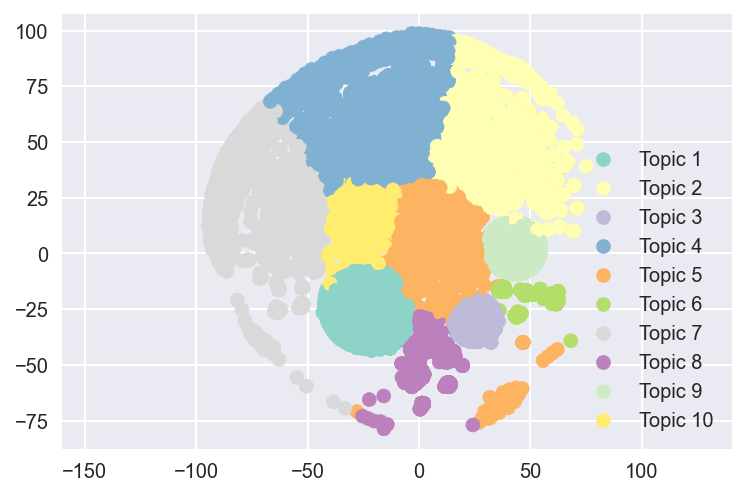

In [ ]:
labels = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10']

scatter = plt.scatter(tsne_d[:, 0], tsne_d[:, 1], c=pre, cmap='Set3')
handles, _ = scatter.legend_elements(prop='colors')
plt.axis('equal')
plt.legend(handles, labels,loc='lower right')